In [1]:
import vitaldb
import pandas as pd
import requests
import json
import io
import time  # Importer time-modulet
import numpy as np

In [20]:
#Tracklist inneholder informationene: case identifier, track name(navnet på målingen og apparat), 

# track identifier (den konkrete patients konktere måling)
track_list_url = "https://api.vitaldb.net/trks"
df_tracklist = pd.read_csv("C:/Users/johns/Downloads/VitalDB_Tracks.csv") #Skriv tracklist_url inne i parantesen

# Hent laboratoriedata fra API
laboratory_list_url = "https://api.vitaldb.net/labs"
df_laboratory = pd.read_csv(laboratory_list_url)

#Download clinical information
clinical_information_url = "https://api.vitaldb.net/cases"
df_clinical= pd.read_csv(clinical_information_url)

In [ ]:

pat_in_ICU = pd.read_csv("C:/Users/johns/Documents/10semester/P10/For_machinelearning/number_of_days_in_ICU.csv")

pat_in_ICU = pat_in_ICU[['caseid', 'icu_days_binary']]

ICU_patients = []
non_ICU_patients = []

#print(pat_in_ICU['caseid'].head())

#df_laboratory[df_laboratory['caseid'] == value]

def divide_into_ICU_and_non_ICU_patients():
    for index, row in pat_in_ICU.iterrows():
        if pat_in_ICU[pat_in_ICU['icu_days_binary'] == 1]:
            ICU_patients = pat_in_ICU['caseid']
        else: 
            non_ICU_patients = pat_in_ICU['caseid']

divide_into_ICU_and_non_ICU_patients()



0    1
1    2
2    3
3    4
4    5
Name: caseid, dtype: int64


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [21]:
# DENNE FUNGERER NÅ!!!!!!!!!!!!!!!!  

#Denne funksjon henter tracks ned fra en URL, og printer dem. Deretter vil en tjekke hvor mange 0
# verdier som er i trakcet. Deretter vil den gemme tracket hvis trakcet har mindre enn et hvis antall 0 verdier#
# Opprett en liste for lagring av data som skal skrives til CSV

# Liste for spesielle variabler
special_variables = {
    "SNUADC/ART", "SNUADC/CVP", "SNUADC/ECG_II", "SNUADC/ECG_V5",
    "SNUADC/FEM", "SNUADC/PLETH", "Primus/AWP", "Primus/CO2",
    "BIS/EEG1_WAV", "BIS/EEG2_WAV", "CardioQ/ABP", "CardioQ/FLOW"
}

# Liste for å lagre data som skal skrives til CSV
saved_tracks = []

def collect_track_null_checker():
    # Hent hver trackidentifierverdi
    for index, row in df_tracklist.iterrows():
        if row['tname'] in special_variables:
            trackidentifier = row["tid"]
            trackdata_url = f"https://api.vitaldb.net/{trackidentifier}"
            response = requests.get(trackdata_url)

            # Konverter API-respons til en pandas DataFrame
            trackdata = pd.read_csv(io.StringIO(response.text))

            data_column = trackdata.columns[1]  # Velger den andre kolonnen (indeks 1)

            # Tell antall nullverdier
            zero_count = (trackdata[data_column] == 0).sum().sum()
            # Tell antall NaNverdier
            nan_count_per_column = trackdata[data_column].isna().sum().sum()

            total_non_value = zero_count+nan_count_per_column
            
            size = trackdata[data_column].size

            samplingfrequency = trackdata.iloc[0,1]

            # Sjekk om mer enn 20% av verdiene er null
            
            if total_non_value >= 0.2 * size:
                print(f"NO.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
            else:
                
                print(f"Saved.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
                # Lagre caseid, tname og tid
                saved_tracks.append([row["caseid"], row["tname"], row["tid"], nan_count_per_column, zero_count, size, samplingfrequency])

            # Vent 2 sekunder før neste forespørsel
            time.sleep(2)

    # Konverter listen til en DataFrame og lagre som CSV
    if saved_tracks:
        df_saved_tracks = pd.DataFrame(saved_tracks, columns=["caseid", "tname", "tid", "nan_count_per_column","zero_count", "size", "samplingfrequency"])
        df_saved_tracks.to_csv("saved_tracks.csv", index=False)
        print("CSV file 'saved_tracks.csv' has been saved.")
    else:
        print("No tracks met the criteria for saving.")

# Kjør funksjonen
collect_track_null_checker()



Saved.This track, BIS/EEG1_WAV, has 418 0s, 164 NAN, combined 582 non informatory values out of 1477268 samples
Saved.This track, BIS/EEG2_WAV, has 235 0s, 164 NAN, combined 399 non informatory values out of 1477268 samples
CSV file 'saved_tracks.csv' has been saved.


In [ ]:
pd.set_option('display.max_rows', None)
def count_tracks ():
    counts = df_tracklist['tname'].value_counts()
    display(counts)
        
count_tracks()

tname
Solar8000/HR                6387
Solar8000/PLETH_HR          6386
Solar8000/PLETH_SPO2        6386
Primus/CO2                  6362
Primus/PAMB_MBAR            6361
Primus/SET_AGE              6361
Primus/AWP                  6360
SNUADC/ECG_II               6355
Primus/VENT_LEAK            6344
Primus/ETCO2                6339
Primus/FEN2O                6339
Primus/FIN2O                6339
Primus/INCO2                6339
Primus/MAC                  6338
Primus/MAWP_MBAR            6338
Primus/FEO2                 6335
Primus/FIO2                 6335
Primus/RR_CO2               6328
Solar8000/VENT_MAWP         6299
Solar8000/ETCO2             6242
Solar8000/INCO2             6242
Solar8000/FEO2              6239
Solar8000/FIO2              6239
Solar8000/RR_CO2            6177
SNUADC/PLETH                6157
Primus/SET_FIO2             6047
Primus/SET_FRESH_FLOW       6042
Primus/MV                   6022
Primus/TV                   6018
Primus/COMPLIANCE           6017
Prim

In [10]:

def count_lab_results ():
    counts=df_laboratory.groupby('name')['caseid'].nunique()
    display(counts)
        
count_lab_results()


def collect_laboratory_values_two_inputs(caseid, var_name):
    """
    Henter laboratorieværdier for en given patient (caseid) og en specifik laboratorievariabel (var_name).
    """
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Ugyldig input, vennligst bruk en integer for caseid og en string for variabelnavn"
    
    # Filtrer på både caseid og variabelnavn
    filtered_df = df_laboratory[(df_laboratory['caseid'] == caseid) & (df_laboratory['name'] == var_name)]
    
    # Hvis ingen resultater findes
    if filtered_df.empty:
        return f"Ingen data fundet for caseid {caseid} og variabel '{var_name}'"
    
    return filtered_df[['dt', 'result']]  # Returner kun tid og resultat

# Eksempel på kald
caseid_test = 2  # Erstat med en reel caseid
variable_test = "alb"  # Erstat med en reel laboratorievariabel

#print(collect_laboratory_values_two_inputs(caseid_test, variable_test))

#Denne funksjonen krevet et input, enten caseid eller variabelnavn. 
# Henter enten all information ift caseif eller all information ift variabelnavn

def collect_laboratory_values(value):
    if isinstance(value, int):  # Hvis input er patient caseid
        filtered_df = df_laboratory[df_laboratory['caseid'] == value]
        data_array = filtered_df[['dt', 'name', 'result']].values
        return [['dt', 'name', 'result']] + data_array.tolist()  # Include column names

    elif isinstance(value, str):  # Hvis input er en variabelnavn
        filtered_df = df_laboratory[df_laboratory['name'] == value]
        data_array = filtered_df[['dt', 'caseid', 'result']].values
        return [['dt', 'caseid', 'result']] + data_array.tolist()  # Include column names

    else:
        return "Ugyldig input, vennligst bruk enten en integer eller en string"

# Test function
#collect_laboratory_values(1)  # Example caseid
#collect_laboratory_values("alb") # Example variable name


name
alb      5278
alt      5279
ammo      102
aptt     4437
ast      5279
be        897
bun      5170
ccr       242
cl       5250
cr       5170
crp      4669
esr       663
fib      4302
gfr      5144
gluc     5091
hb       5371
hco3     3483
hct      5457
ica      3745
k        5402
lac      3473
na       5402
p        2724
pco2     3483
ph       3483
plt      5369
po2      3483
pt%      4446
ptinr    4446
ptsec    4446
sao2     3483
tbil     5278
tprot    5278
wbc      5371
Name: caseid, dtype: int64

        Time  BIS/EEG1_WAV
0   0.000000         22.85
1   0.007812         22.90
2        NaN         23.05
3        NaN         23.30
4        NaN         23.70
5        NaN         23.50
6        NaN         22.70
7        NaN         22.75
8        NaN         22.95
9        NaN         22.85
10       NaN         22.90
11       NaN         22.80
12       NaN         22.95
13       NaN         23.45
14       NaN         23.25
15       NaN         22.75
16       NaN         22.65
17       NaN         22.65
18       NaN         22.75
19       NaN         22.80
20       NaN         22.50
21       NaN         22.90
22       NaN         23.25
23       NaN         23.10
24       NaN         23.25
25       NaN         23.10
26       NaN         22.40
27       NaN         22.65
28       NaN         23.15
29       NaN         23.05
30       NaN         22.90
31       NaN         23.05
32       NaN         22.90
33       NaN         22.80
34       NaN         22.85
35       NaN         22.60
3

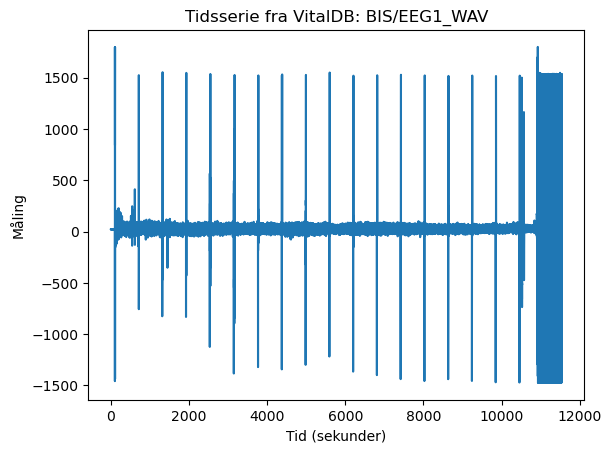

In [16]:
#HVIS MAN VIL PLOTTE ET Waveform data track. 
pd.set_option("display.max_rows", None)  # Vis alle rader
import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/0aa685df768489a18a5e9f53af0d83bf60890c73"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata.iloc[:100]) 


#Henter ut signalfrekvensen, men bruker den ikke til noe her
signal_frequency = trackdata.iloc[1, 0]

#Starttid og endetidspunkt af signalet
start_time = trackdata.iloc[0,0]
end_time = trackdata.iloc[-1,0]
num_samples = len(trackdata)


# Generér tidsakse fra start til slut med korrekt sampling-rate
#time_axis = np.arange(start_time, end_time, signal_frequency)
time_axis = np.linspace(start_time, end_time, num_samples)

# Sikrer at tidsaksen har samme længde som trackdata
time_axis = time_axis[:len(trackdata)]

plt.plot(time_axis, trackdata.iloc[:, 1]) # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
#plt.xlim(100, 120)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()

        Time  Primus/PEEP_MBAR
0    352.872                 2
1    359.030                 1
2    365.286                 2
3    371.524                 3
4    377.891                 2
..       ...               ...
95   996.979                 1
96  1003.120                 1
97  1009.440                 1
98  1015.850                 1
99  1022.190                 1

[100 rows x 2 columns]


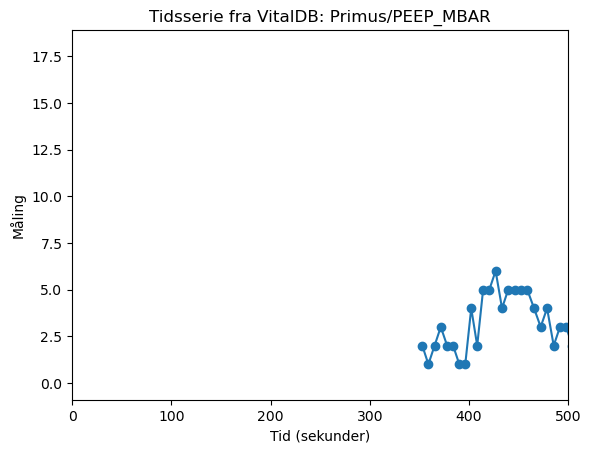

In [6]:
#HVIS MAN VIL PLOTTE ET Numeric data track. 

import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/3be29dcf1674c9dc74a57d1b6fe32ca43f08313d"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata[0:100])


plt.plot(trackdata["Time"], trackdata.iloc[:, 1], marker='o', linestyle='-') # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
plt.xlim(0, 500)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()